# Automatic Seismic to Well Tie

#### Import packages

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import yaml

from wtie import grid, autotie, viz
from wtie.utils.datasets import tutorial

from pprint import pprint

import matplotlib.pyplot as plt

# uncomment if your browser supports it
#%matplotlib notebook 

### Import data


In this tutorial we work on data from the Well *Torosa1* of the open [Poseidon](https://terranubis.com/datainfo/NW-Shelf-Australia-Poseidon-3D) dataset. Data is saved in the folder **data/tutorial**.

In [2]:
# data path
folder = Path('../data/tutorial')
assert folder.exists()

inputs = tutorial.load_poseidon_data(folder, well='torosa1')

### Load pretrained network to extract the wavelet

In [3]:
# neural network's weights
model_state_dict = folder / 'trained_net_state_dict.pt'
assert model_state_dict.is_file()

# network training paramters
with open(folder / 'network_parameters.yaml', 'r') as yaml_file:
    training_parameters = yaml.load(yaml_file, Loader=yaml.Loader)
    
wavelet_extractor = tutorial.load_wavelet_extractor(training_parameters, model_state_dict)

Loading network parameters from ../data/tutorial/trained_net_state_dict.pt


### Load synthetic modeling tool

In [4]:
modeler = tutorial.get_modeling_tool()

### Parameters for the search

In [5]:
print(autotie.tie_v1.__doc__)


    Utility to perform automatic (prestack) seismic to well tie. This version 1
    serves as a base recipe. Feel free to implement your own recipe using the
    various tools of the package.

    Parameters
    ----------
    inputs : _tie.InputSet
        Necessary inputs for the well tie.
    wavelet_extractor : wtie.learning.model.BaseEvaluator
        Object to extract a wavelet using the provided neural network.
    modeler : wtie.modeling.modeling.ModelingCallable
        Synthetic modeling tool.
    wavelet_scaling_params : dict
        Parameters for the search of the optimal absolute wavelet sacle.
        3 parameters: 'wavelet_min_scale' and 'wavelet_max_scale' are the search
        bounds. 'num_iters' (optional) is the total number of iterations for the
        search.
    search_space : dict, optional
        Bounds of the search space. See `get_default_search_space_v1`.
    search_params : dict, optional
        Dict with 3 parameters for the Bayesian search. 'num_iter

#### Define the tie parameters search space (optional)

So far, supported parameters correspond to the log filtering and depth to time table bulk shift. See the `tie.get_default_search_space_v1` docstring.

In [6]:
print(autotie.get_default_search_space_v1.__doc__)


    Search space of version 1 is composed of 4 parameters:
        - "logs_median_size" : size (in number of samples) of the median filter window.
        - "logs_median_threshold" : threshold value with respect to the logs standard deviation.
        - "logs_std" : standard deviation of the gaussian smoothing filter.
        - "table_t_shift" : bulk shift in seconds of the depth-time relation table.

    Parameters are defined following the [Ax](https://github.com/facebook/Ax)
    documentation.


In [7]:

# Logs processing
median_length_choice = dict(name="logs_median_size", type="choice",
                  values=[i for i in range(11,63,2)], value_type="int")

median_th_choice = dict(name="logs_median_threshold", type="range",
                  bounds=[0.1, 5.5], value_type="float")

std_choice = dict(name="logs_std", type="range",
                  bounds=[0.5, 5.5], value_type="float")


# bulk shift in seconds
table_t_shift_choice = dict(name="table_t_shift", type="range",
                  bounds=[-0.012, 0.012], value_type="float")


search_space = [median_length_choice,
                median_th_choice,
                std_choice,
                table_t_shift_choice
                ]

#### Bayesian search parameters (optional)

In [8]:
search_params = dict(num_iters=80, similarity_std=0.02)

#### Wavelet absolute amplitude search params

In [9]:
wavelet_scaling_params = dict(wavelet_min_scale=50000, wavelet_max_scale=500000, num_iters=60)

### Optimization

In [10]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


outputs = autotie.tie_v1(inputs,
                         wavelet_extractor,
                         modeler,
                         wavelet_scaling_params,
                         search_params=search_params,
                         search_space=search_space,
                         stretch_and_squeeze_params=None) 

[WARNING 09-30 17:01:15] ax.core.parameter: `sort_values` is not specified for `ChoiceParameter` "logs_median_size". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.


Search for optimal parameters


  0%|          | 0/80 [00:00<?, ?it/s][WARNING 09-30 17:01:16] ax.core.parameter: `sort_values` is not specified for `ChoiceParameter` "logs_median_size". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
[WARNING 09-30 17:01:16] ax.core.parameter: `sort_values` is not specified for `ChoiceParameter` "logs_median_size". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
[WARNING 09-30 17:01:16] ax.core.parameter: `sort_values` is not specified for `ChoiceParameter` "logs_median_size". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
[WARNING 09-30 17:01:16] ax.core.parameter: `sort_values` is not specified for `ChoiceParameter

Find wavelet absolute scale


100%|██████████| 60/60 [00:41<00:00,  1.43it/s]


#### QC optimization

In [11]:
best_parameters, values = outputs.ax_client.get_best_parameters()
means, covariances = values
print(means)
print(covariances)

{'goodness_of_match': 0.8684428020823923}
{'goodness_of_match': {'goodness_of_match': 4.8940026e-05}}


In [12]:
pprint(best_parameters)

{'logs_median_size': 13,
 'logs_median_threshold': 2.5922806680202486,
 'logs_std': 2.9336816370487213,
 'table_t_shift': 0.009191940307617188}


[WARNING 09-30 17:02:34] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


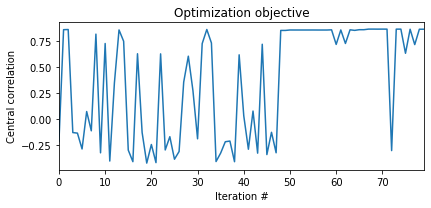

In [13]:
outputs.plot_optimization_objective();

### Visualize results

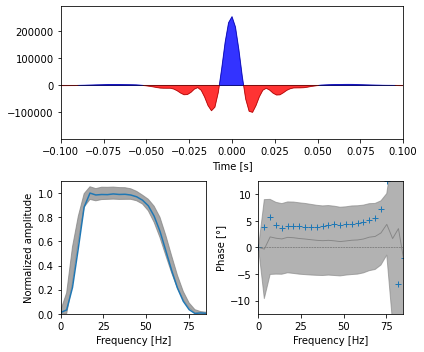

In [14]:
fig, axes = outputs.plot_wavelet(fmax=85, phi_max=15, figsize=(6,5))
axes[0].set_xlim((-0.1,0.1))
axes[2].set_ylim((-12.5,12.5))
fig.tight_layout()

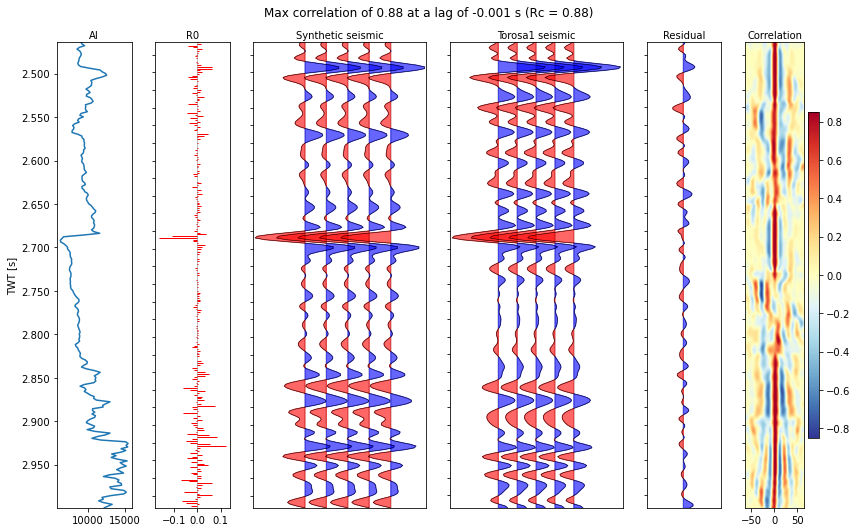

In [15]:
_scale = 120000
fig, axes = outputs.plot_tie_window(wiggle_scale=_scale, figsize=(12.,7.5))

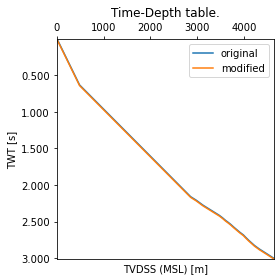

In [16]:
fig,ax = viz.plot_td_table(inputs.table, plot_params=dict(label='original'))
viz.plot_td_table(outputs.table,  plot_params=dict(label='modified'), fig_axes=(fig,ax))
ax.legend(loc='best')

#### Test automatic Stretch & Squeeze

In [17]:
s_and_s_params = dict(window_length=0.060, max_lag=0.010) # in seconds

outputs2 = autotie.stretch_and_squeeze(inputs,
                                       outputs,
                                       wavelet_extractor,
                                       modeler,
                                       wavelet_scaling_params,
                                       best_parameters,
                                       s_and_s_params)

Find wavelet absolute scale


100%|██████████| 60/60 [00:51<00:00,  1.17it/s]


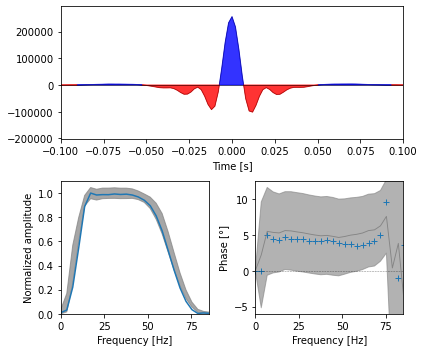

In [18]:
fig, axes = outputs2.plot_wavelet(fmax=85, phi_max=25, figsize=(6,5))
axes[0].set_xlim((-0.1,0.1))
axes[2].set_ylim((-6.,12.5))
fig.tight_layout()

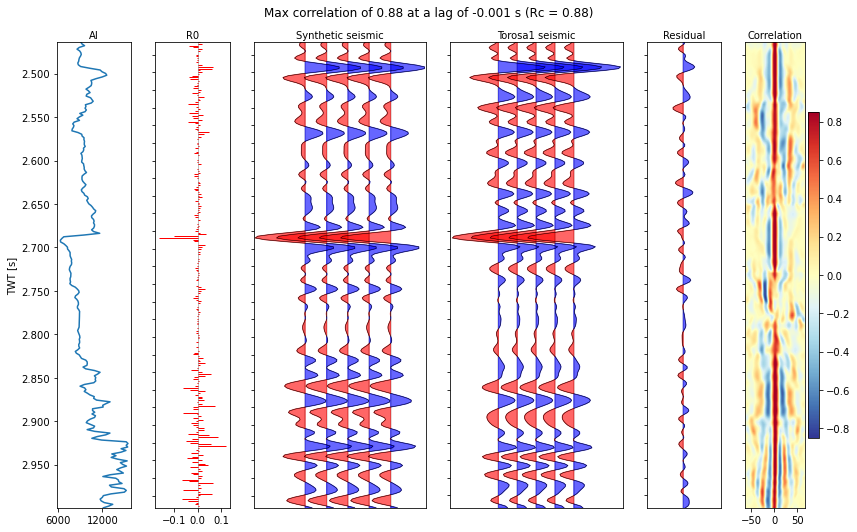

In [19]:
fig, axes = outputs2.plot_tie_window(wiggle_scale=_scale, figsize=(12.,7.5));
from matplotlib.ticker import MaxNLocator
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=2))

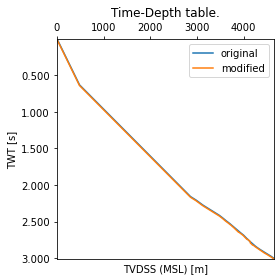

In [20]:
fig,ax = viz.plot_td_table(inputs.table, plot_params=dict(label='original'))
viz.plot_td_table(outputs2.table,  plot_params=dict(label='modified'), fig_axes=(fig,ax))
ax.legend(loc='best')

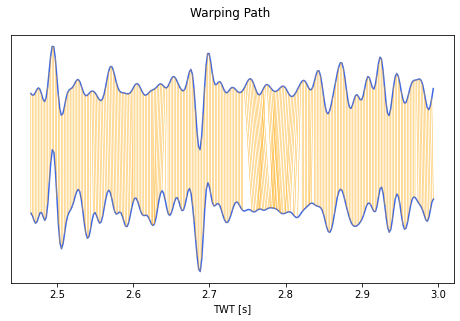

In [21]:
fig, ax = viz.plot_warping(outputs.synth_seismic, outputs.seismic, outputs2.dlags)